In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 40
n_loci = 50
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

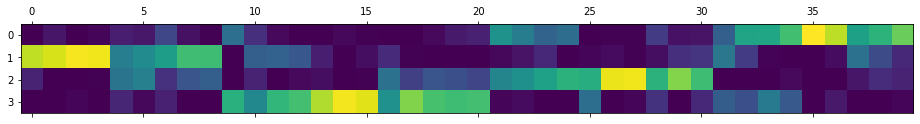

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(40, 50, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 30

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 30, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (40, 29, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

init_vb_params_dict = deepcopy(vb_params_dict)

In [12]:
## get initial e_z
t0 = time.time()
e_log_sticks, e_log_1m_sticks, \
        e_log_pop_freq, e_log_1m_pop_freq = \
            structure_model_lib.get_moments_from_vb_params_dict(g_obs, \
                                    vb_params_dict, use_logitnormal_sticks)

e_z_init = cavi_lib.update_z(g_obs, e_log_sticks, e_log_1m_sticks, e_log_pop_freq,
                                e_log_1m_pop_freq)

print('e_z_init time: {:.03f}sec'.format(time.time() - t0))

e_z_init time: 0.021sec


In [13]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_opt_dict['ind_mix_stick_propn_mean'], 
                            vb_opt_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

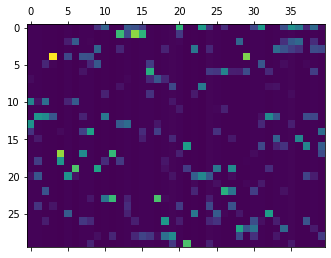

In [14]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

# Run CAVI

In [15]:
run_svi = True

In [16]:
if run_svi: 
    ez_cavi, vb_cavi_dict, kl_vec, _ = \
        cavi_lib.run_svi(g_obs, deepcopy(init_vb_params_dict),
                    prior_params_dict,
                    e_z_init,
                    use_logitnormal_sticks,
                    batchsize = 5,
                    x_tol = 1e-2,
                    max_iter = 10000,
                    print_every = 20,
                    local_x_tol = 1e16)
else: 
    ez_cavi, vb_cavi_dict, kl_vec, _ = \
        cavi_lib.run_cavi(g_obs, deepcopy(init_vb_params_dict),
                            prior_params_dict,
                            use_logitnormal_sticks, 
                            max_iter = 1000)


iteration [20]; kl:6920.808086; elapsed: 0.281secs
iteration [40]; kl:5897.493292; elapsed: 0.2301secs
iteration [60]; kl:5351.625333; elapsed: 0.1647secs
iteration [80]; kl:5066.749833; elapsed: 0.152secs
iteration [100]; kl:4884.936115; elapsed: 0.1145secs
iteration [120]; kl:4756.443129; elapsed: 0.127secs
iteration [140]; kl:4679.43844; elapsed: 0.1221secs
iteration [160]; kl:4628.780408; elapsed: 0.2856secs
iteration [180]; kl:4585.262273; elapsed: 0.1471secs
iteration [200]; kl:4552.92793; elapsed: 0.1449secs
iteration [220]; kl:4530.078867; elapsed: 0.1129secs
iteration [240]; kl:4510.382663; elapsed: 0.1273secs
iteration [260]; kl:4486.34869; elapsed: 0.1172secs
iteration [280]; kl:4469.912964; elapsed: 0.1293secs
iteration [300]; kl:4456.306044; elapsed: 0.1132secs
iteration [320]; kl:4447.544858; elapsed: 0.124secs
iteration [340]; kl:4440.422541; elapsed: 0.125secs
iteration [360]; kl:4434.726962; elapsed: 0.126secs
iteration [380]; kl:4428.921605; elapsed: 0.1137secs
iterat

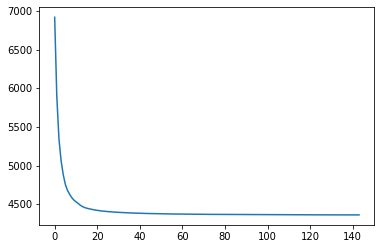

In [17]:
plt.plot(kl_vec)

In [18]:
vb_cavi_free = vb_params_paragami.flatten(vb_cavi_dict, free = True)

In [19]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, use_logitnormal_sticks = use_logitnormal_sticks)


In [20]:
import scipy as osp

In [21]:
cluster_quantities_lib.get_e_num_clusters_from_ez(ez_cavi.transpose(0, 1, 3, 2).reshape(-1, k_approx))

14.70652242218527

### We will compare against the linear sensitivy at the "true" optimum

In [22]:
continue_with_newton = True

if continue_with_newton: 
    
    get_loss = lambda x : objective_fun(x, prior_params_free)
    get_loss_objective = paragami.OptimizationObjective(get_loss)
    
    res = osp.optimize.minimize(
                fun=get_loss_objective.f,
                jac=get_loss_objective.grad,
                hessp=get_loss_objective.hessian_vector_product,
                x0=deepcopy(vb_cavi_free), 
                method='trust-ncg', options={'disp':True})
    
    
    print('\nlinf diff in vb_params: ', np.abs(res.x - vb_cavi_free).max())
    
    vb_newton_free = deepcopy(res.x)
    vb_newton_dict = vb_params_paragami.fold(vb_newton_free, free = True)
    ez_newton = str_opt_lib.get_e_z_from_vb_params_dict(g_obs, vb_newton_dict, use_logitnormal_sticks)


Iter 0: f = 4360.05268931
Iter 1: f = 4357.69181385
Iter 2: f = 4354.57237725
Iter 3: f = 4348.88601275
Iter 4: f = 4353.05654724
Iter 5: f = 4343.85941251
Iter 6: f = 4339.35173083
Iter 7: f = 4332.79800280
Iter 8: f = 4333.37139920
Iter 9: f = 4326.01875900
Iter 10: f = 4323.04874856
Iter 11: f = 4320.76134415
Iter 12: f = 4318.41335607
Iter 13: f = 4315.27165993
Iter 14: f = 4313.16484687
Iter 15: f = 4312.69736413
Iter 16: f = 4311.20945848
Iter 17: f = 4310.92789322
Iter 18: f = 4310.84090935
Iter 19: f = 4310.77534030
Iter 20: f = 4310.76983010
Iter 21: f = 4310.76909067
Iter 22: f = 4310.76905912
Iter 23: f = 4310.76905905
Optimization terminated successfully.
         Current function value: 4310.769059
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 22
         Hessian evaluations: 149

linf diff in vb_params:  4.1287842689309375


# Check results

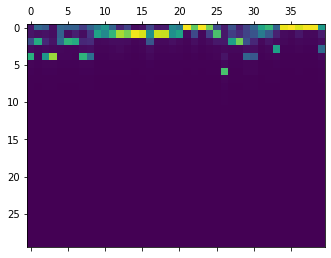

In [23]:
plt.matshow(get_vb_expectations(vb_cavi_dict, use_logitnormal_sticks)[0].transpose())

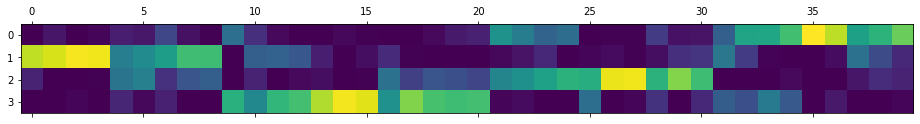

In [24]:
plt.matshow(true_ind_admix_propn.transpose())

# Check optimum

In [25]:
# get hessian 
t0 = time.time()

get_full_hess = False
if get_full_hess: 
    get_hess = autograd.hessian(objective_fun, argnum = 0)
    hessian_at_cavi_opt = get_hess(vb_cavi_free, prior_params_free)

    print('hessian time: {}sec'.format(np.round(time.time() - t0, 3)))
    hess_cavi_solver = vittles.solver_lib.get_cholesky_solver(hessian_at_cavi_opt)

else:     
    objective_fun_hvp = autograd.hessian_vector_product(objective_fun, argnum = 0)
    hess_cavi_solver = vittles.solver_lib.get_cg_solver(
                        lambda x : objective_fun_hvp(vb_cavi_free, prior_params_free, x),
                                     dim = len(vb_cavi_free))

In [26]:
# gradient 
get_objective_grad = autograd.jacobian(objective_fun, argnum = 0)

In [27]:
optimum_checker = vittles.bivariate_sensitivity_lib.OptimumChecker(
                                                estimating_equation = get_objective_grad, 
                                                solver = hess_cavi_solver, 
                                                input_base = vb_cavi_free, 
                                                hyper_base = prior_params_free)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/vittles/bivariate_sensitivity_lib.py:32: UserWarning: The CrossSensitivity class is very experimental and untested.
  warnings.warn(


In [28]:
newton_step = optimum_checker.get_newton_step()

In [29]:
np.abs(newton_step).max()

4.52985075138901

# Parametric sensitivity

### Hyper parameter sensitivity object

In [30]:
vb_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        estimating_equation = get_objective_grad, 
        input_val0 = vb_cavi_free, 
        hyper_val0 = prior_params_free, 
        order = 1, 
        hess_solver = hess_cavi_solver)


In [31]:
if continue_with_newton: 
    # compare against the linear approximation at the newton optimum
    
    if get_full_hess: 
        t0 = time.time()
        # hessian at newton optimum
        hessian_at_newton_opt = get_hess(vb_newton_free, prior_params_free)

        # solver
        print('hessian time: {}sec'.format(np.round(time.time() - t0, 3)))
        hess_newton_solver = vittles.solver_lib.get_cholesky_solver(hessian_at_newton_opt)
    else: 
        objective_fun_hvp = autograd.hessian_vector_product(objective_fun, argnum = 0)
        hess_newton_solver = vittles.solver_lib.get_cg_solver(
                            lambda x : objective_fun_hvp(vb_newton_free, prior_params_free, x),
                                         dim = len(vb_newton_free))


    # vb sensitivity at the newton optimum
    vb_sens_newton = \
        vittles.ParametricSensitivityTaylorExpansion(
            estimating_equation = get_objective_grad, 
            input_val0 = vb_newton_free, 
            hyper_val0 = prior_params_free, 
            order = 1, 
            hess_solver = hess_newton_solver)


### Set new prior

In [32]:
new_alpha = np.array([4.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [33]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])

initial alpha,  [3.]
perturbed alpha,  [4.]


In [34]:
lr_vb_free_params = \
    vb_sens.evaluate_taylor_series(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True))

if continue_with_newton: 
    lr_newton_vb_free_params = \
        vb_sens_newton.evaluate_taylor_series(
            prior_params_paragami.flatten(prior_params_pert_dict, free = True))


In [35]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_cavi_free)))

l_inf diff:  0.5501747845997573


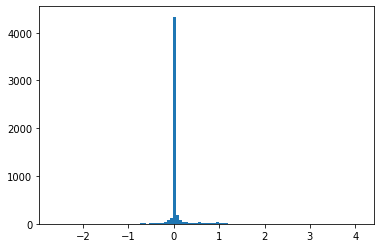

In [36]:
plt.hist(lr_vb_free_params - lr_newton_vb_free_params, bins = 100);

### Re-optimize

In [37]:
new_init_dict = deepcopy(vb_cavi_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [38]:
# get beta parameters for sticks and populations
ez_pert, vb_pert_dict, _, _ = \
    cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                        prior_params_pert_dict,
                        use_logitnormal_sticks, 
                        max_iter = 1000,
                        f_tol = 1e-4)


iteration [1]; kl:4780.922449; elapsed: 0.049secs
iteration [2]; kl:4775.500517; elapsed: 0.0386secs
iteration [3]; kl:4774.236779; elapsed: 0.0403secs
iteration [4]; kl:4773.623898; elapsed: 0.0397secs
iteration [5]; kl:4773.209282; elapsed: 0.0442secs
iteration [6]; kl:4772.87374; elapsed: 0.0522secs
iteration [7]; kl:4772.575335; elapsed: 0.0608secs
iteration [8]; kl:4772.295822; elapsed: 0.0592secs
iteration [9]; kl:4772.025725; elapsed: 0.0845secs
iteration [10]; kl:4771.759359; elapsed: 0.0939secs
iteration [11]; kl:4771.492908; elapsed: 0.0978secs
iteration [12]; kl:4771.223591; elapsed: 0.0644secs
iteration [13]; kl:4770.949266; elapsed: 0.057secs
iteration [14]; kl:4770.668223; elapsed: 0.0529secs
iteration [15]; kl:4770.379081; elapsed: 0.0465secs
iteration [16]; kl:4770.080728; elapsed: 0.0605secs
iteration [17]; kl:4769.772303; elapsed: 0.0619secs
iteration [18]; kl:4769.453186; elapsed: 0.0463secs
iteration [19]; kl:4769.123009; elapsed: 0.043secs
iteration [20]; kl:4768.7

iteration [159]; kl:4732.769391; elapsed: 0.0334secs
iteration [160]; kl:4732.762722; elapsed: 0.0353secs
iteration [161]; kl:4732.756083; elapsed: 0.1206secs
iteration [162]; kl:4732.749473; elapsed: 0.1271secs
iteration [163]; kl:4732.742892; elapsed: 0.1086secs
iteration [164]; kl:4732.736343; elapsed: 0.0425secs
iteration [165]; kl:4732.729827; elapsed: 0.0304secs
iteration [166]; kl:4732.723346; elapsed: 0.0286secs
iteration [167]; kl:4732.716903; elapsed: 0.028secs
iteration [168]; kl:4732.710502; elapsed: 0.0281secs
iteration [169]; kl:4732.704149; elapsed: 0.0384secs
iteration [170]; kl:4732.697847; elapsed: 0.0353secs
iteration [171]; kl:4732.691602; elapsed: 0.0308secs
iteration [172]; kl:4732.685421; elapsed: 0.0283secs
iteration [173]; kl:4732.679309; elapsed: 0.0287secs
iteration [174]; kl:4732.673274; elapsed: 0.028secs
iteration [175]; kl:4732.667324; elapsed: 0.0312secs
iteration [176]; kl:4732.661465; elapsed: 0.035secs
iteration [177]; kl:4732.655705; elapsed: 0.0299s

In [39]:
vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

### Compare lr vs reoptimizing

In [40]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


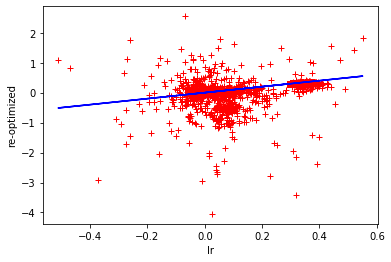

In [41]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, new_init_free)

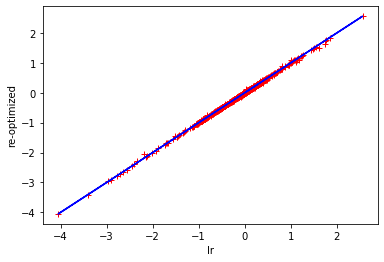

In [42]:
if continue_with_newton: 
    print_diff_plot(lr_newton_vb_free_params, vb_opt_pert, new_init_free)

In [43]:
objective_fun(lr_vb_free_params, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

4777.412674466939

In [44]:
objective_fun(vb_opt_pert, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

4732.535835916715

# Fit for a range of alpha

In [45]:
alpha_list = np.arange(1, 15)

In [46]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha

    # get beta parameters for sticks and populations
    ez_pert, vb_pert_dict, _, _ = \
        cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                            prior_params_pert_dict,
                            use_logitnormal_sticks, 
                            max_iter = 1000,
                            f_tol = 1e-4, 
                             print_every = 1e16)

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert


In [47]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\nre-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



re-optimzing with alpha =  1
CAVI done. Termination after 544 steps in 20.24 seconds

re-optimzing with alpha =  2
CAVI done. Termination after 873 steps in 24.0 seconds

re-optimzing with alpha =  3
CAVI done. Termination after 344 steps in 9.52 seconds

re-optimzing with alpha =  4
CAVI done. Termination after 315 steps in 9.16 seconds

re-optimzing with alpha =  5
CAVI done. Termination after 496 steps in 16.37 seconds

re-optimzing with alpha =  6
CAVI done. Termination after 332 steps in 11.22 seconds

re-optimzing with alpha =  7
CAVI done. Termination after 257 steps in 9.39 seconds

re-optimzing with alpha =  8
CAVI done. Termination after 251 steps in 8.13 seconds

re-optimzing with alpha =  9
CAVI done. Termination after 248 steps in 8.44 seconds

re-optimzing with alpha =  10
CAVI done. Termination after 247 steps in 9.68 seconds

re-optimzing with alpha =  11
CAVI done. Termination after 247 steps in 8.02 seconds

re-optimzing with alpha =  12
CAVI done. Termination after 

In [48]:
lr_list = []
lr_list_newton = []

for alpha in alpha_list: 
    print(alpha)
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response    
    lr_list.append(vb_sens.evaluate_taylor_series(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True)))
    
#     if continue_with_newton: 
#         lr_list_newton.append(vb_sens_newton.evaluate_taylor_series(
#             prior_params_paragami.flatten(prior_params_pert_dict, free = True)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14


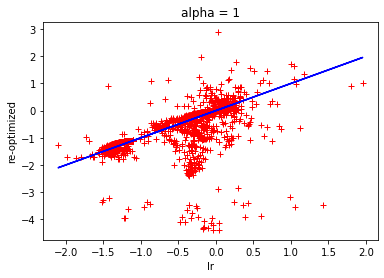

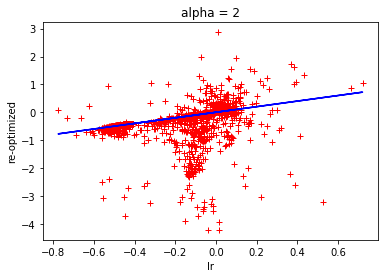

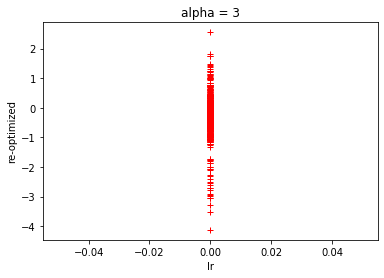

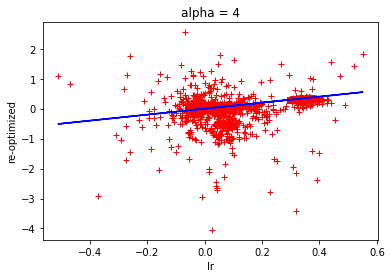

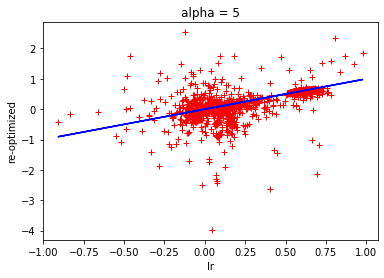

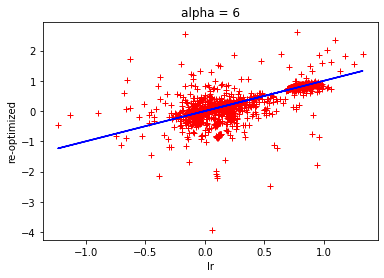

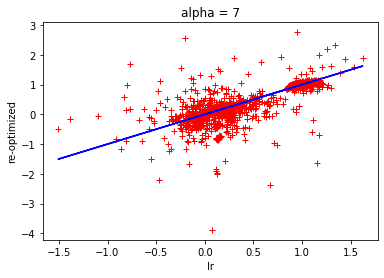

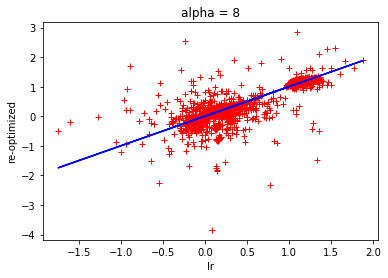

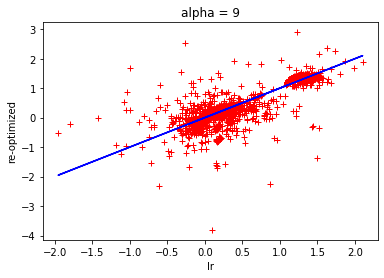

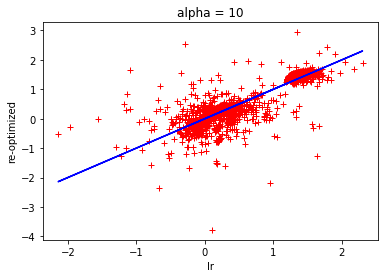

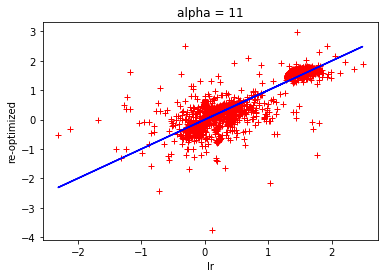

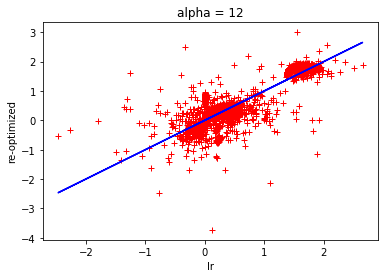

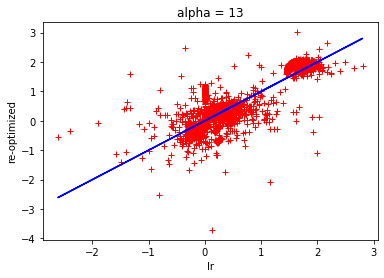

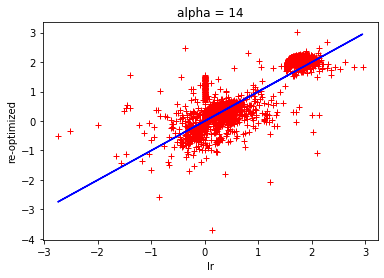

In [49]:
for i in range(len(alpha_list)): 

    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], new_init_free)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


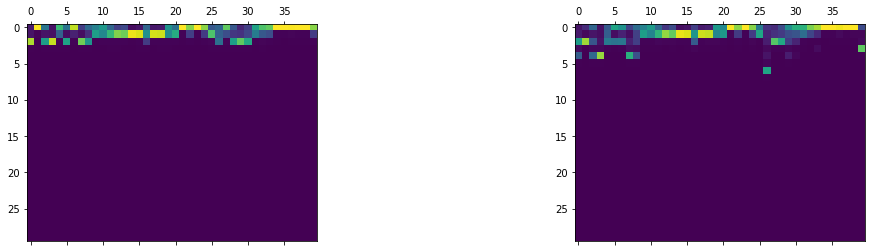

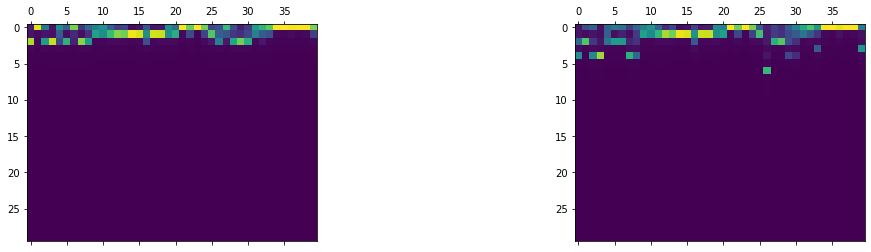

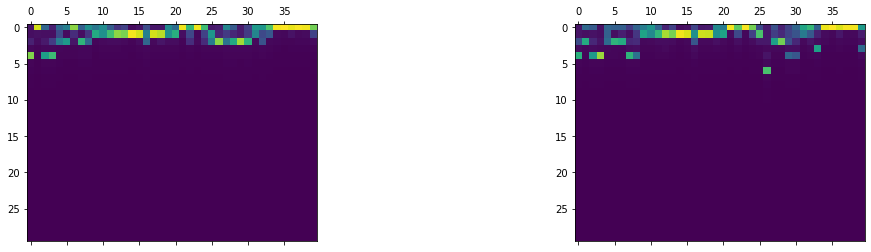

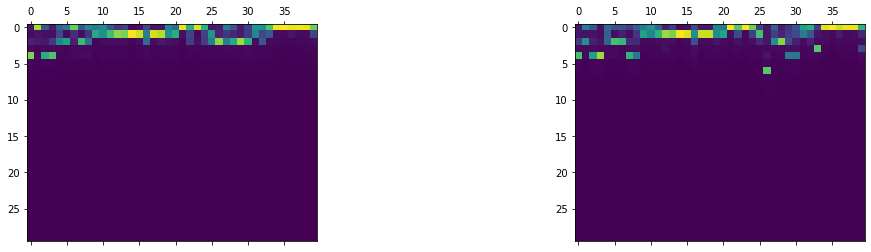

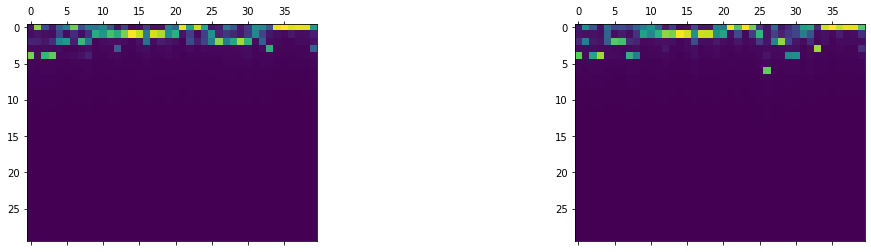

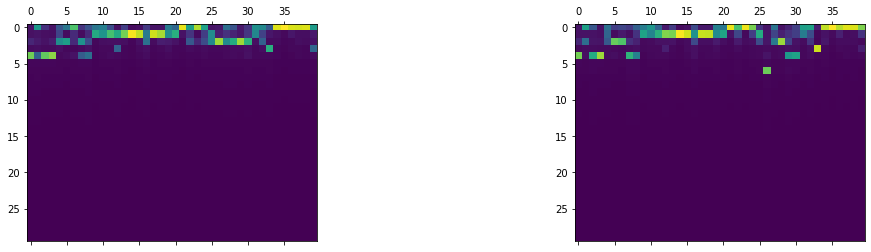

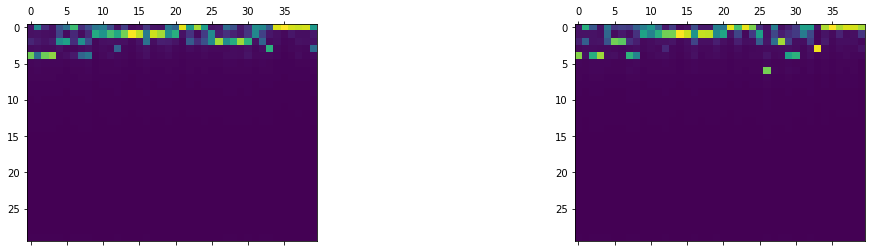

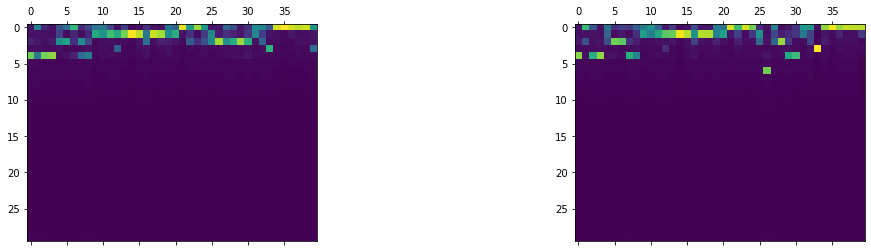

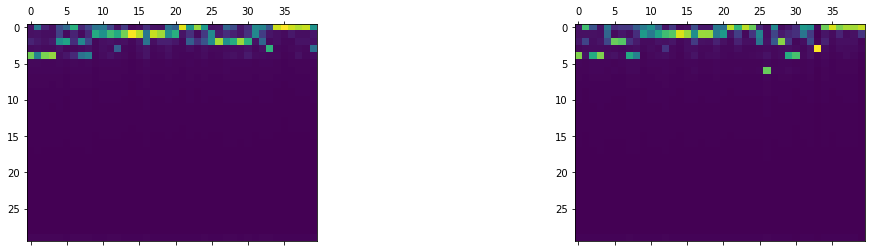

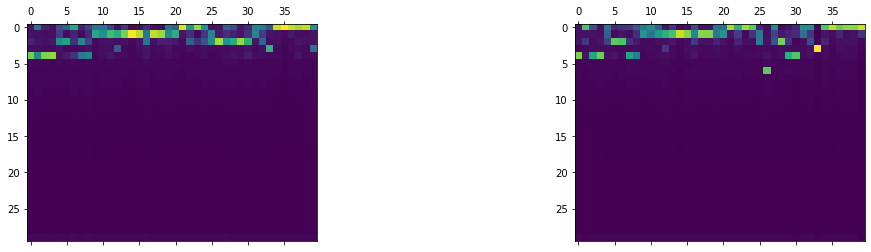

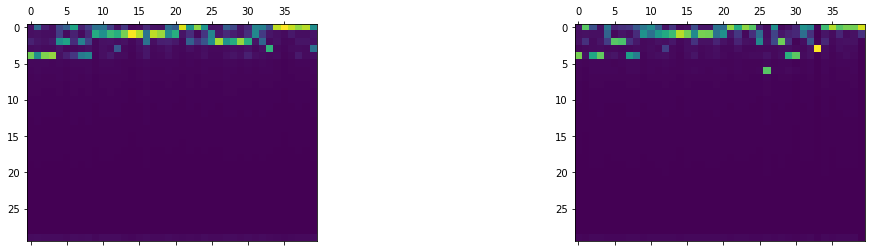

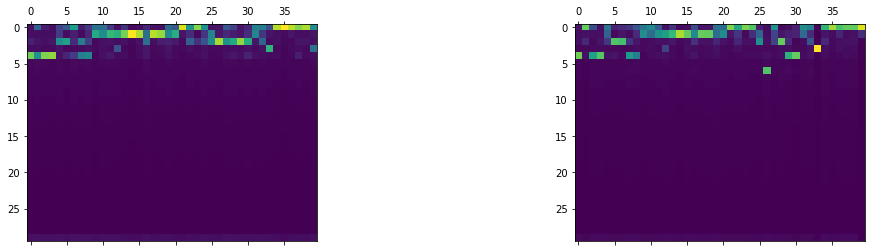

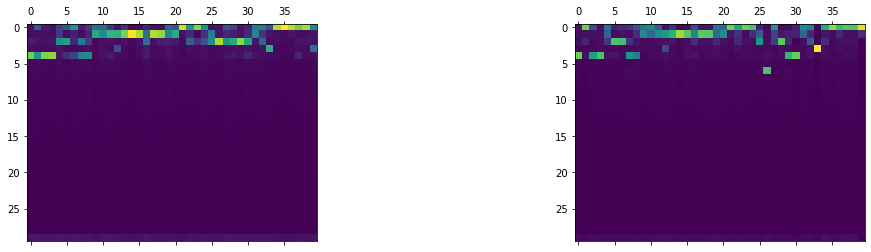

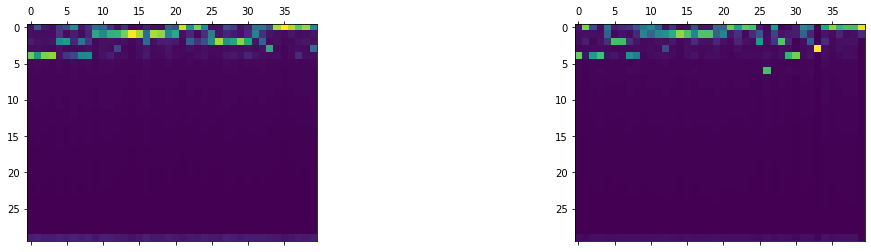

In [50]:
for i in range(len(alpha_list)): 

    fig, axes = plt.subplots(1, 2, figsize = (18, 4))

    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    
    axes[0].matshow(get_vb_expectations(pert_dict, use_logitnormal_sticks)[0].transpose())
    axes[1].matshow(get_vb_expectations(lr_dict, use_logitnormal_sticks)[0].transpose())


### Examine expected number of clusters

In [51]:
def get_ez_from_vb_dict(vb_params_dict): 
    e_log_sticks, e_log_1m_sticks, \
        e_log_pop_freq, e_log_1m_pop_freq = \
            structure_model_lib.get_moments_from_vb_params_dict(g_obs, \
                                    vb_params_dict, use_logitnormal_sticks)

    e_z = cavi_lib.update_z(g_obs, e_log_sticks, e_log_1m_sticks, e_log_pop_freq,
                                    e_log_1m_pop_freq)
    
    return e_z


In [52]:
e_num_clusters_lr = np.zeros(len(alpha_list))
e_num_clusters_pert = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)

    # get expected e_z
    ez_lr = get_ez_from_vb_dict(lr_dict)
    ez_pert = get_ez_from_vb_dict(pert_dict)
    
    e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(\
                                            ez_lr.transpose(0, 1, 3, 2).reshape(-1, k_approx))
    
    e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(\
                                            ez_pert.transpose(0, 1, 3, 2).reshape(-1, k_approx))
    

Text(0, 0.5, 'expected number of clusters')

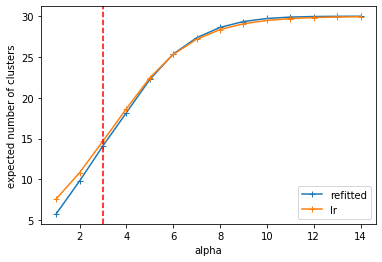

In [53]:
plt.plot(alpha_list, e_num_clusters_pert, '+-')
plt.plot(alpha_list, e_num_clusters_lr, '+-')

plt.axvline(x = prior_params_dict['dp_prior_alpha'], linestyle = '--', color = 'r')

plt.legend(('refitted', 'lr'))

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')